<a href="https://colab.research.google.com/github/jsuj1th/Buildings-Classification/blob/main/buildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50,InceptionResNetV2
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2, DenseNet121, VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir_train = pathlib.Path("drive/MyDrive/data2024Sep/data2024Sep/train")
data_dir_val =   pathlib.Path("drive/MyDrive/data2024Sep/data2024Sep/validation")




In [4]:

img_height, img_width = 224, 224  # ResNet expects 224x224 images
batch_size = 32

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_val,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 4330 files belonging to 15 classes.
Found 1218 files belonging to 15 classes.


In [5]:
class_names = train_ds.class_names
print(len(class_names))


15


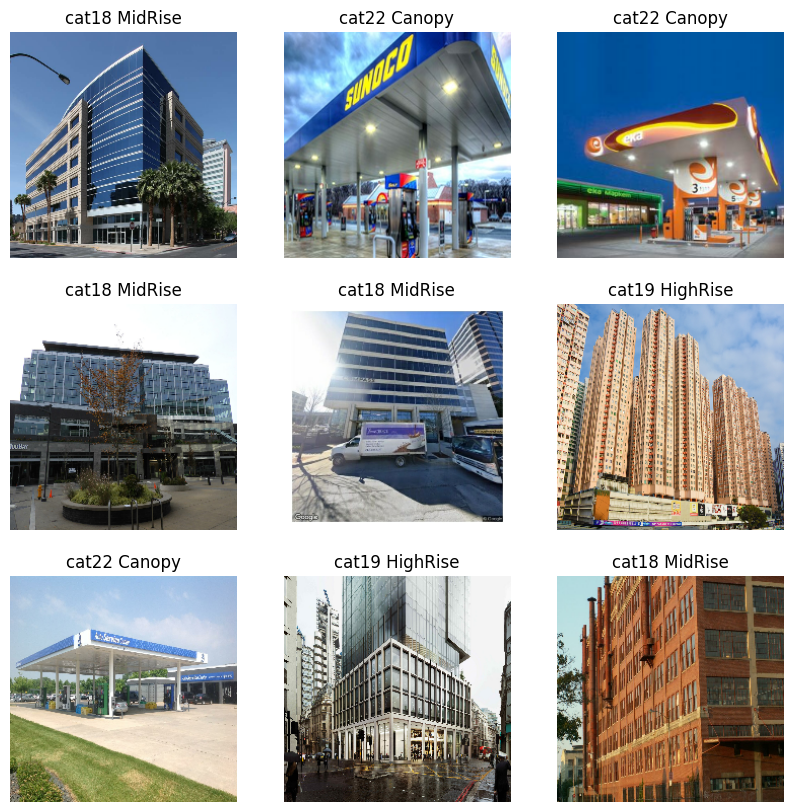

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [8]:


# num_classes = len(class_names)
# num_classes=15

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])





# Normalize pixel values to [0, 1]

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath='inceptionresnet.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,  # Important: save the full model
            mode='max',
            verbose=1,
            # include_optimizer=True
        )


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.Conv2D(1024, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    # layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),  # Reduces feature maps to a single vector per image
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),  # Regularization to prevent overfitting
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),  # Regularization to prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer with class count
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1512s 11s/step - accuracy: 0.5459 - loss: 1.5033 - val_accuracy: 0.2414 - val_loss: 24.1137
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1515s 11s/step - accuracy: 0.6966 - loss: 0.9241 - val_accuracy: 0.3892 - val_loss: 3.0574
Epoch 3/10
 72/136 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - accuracy: 0.7403 - loss: 0.7733 

In [ ]:
# prompt: validate model for accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
